# Generating Mock Data for Spatial Data Science

*Mock data is useful to design new experiments, test new analytical techniques, evaluating the performance of data systems, and to generally get a handle on a new analytical problem, among other things. In some instances, mock data is the goal - think video games or other virtual worlds that need to have endless horizons. In other cases, mock data is to help us think through a problem or test a system. This later case is our primary use in spatial data science, where mock data helps us think through the data modeling challenge. Specifically, it helps us think about the pros and cons of different approaches to problem formulation, abstraction, and representation of the spatial entities and their attributes.*

Last updated: Nov 16, 2023

In [1]:
# Imports
import os
from math import sqrt

os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi
from shapely.geometry import LineString, Point, Polygon

# Multivariate Distributions
A multivariate distribution is simply a probablity distribution that uses multiple random variables. They are really just an extension of the single variate distributions that are covered in their own notebook.

In Python, we can use the NumPy package to create multivariate distributions very quickly, which we will do in the following cells. However, we can use many different probability distributions to create our data with. A probability distribution simply shows us the probability of a variable being a certain value. In practice, we want to use whatever distribution most closely aligns with whatever we are trying to model. To learn more about some of the options for different probability distributions that we can use, see the notebook on single variate distributions.

### Points
To create random points, we can use a multivariate distribution to model two variables, the X and Y coordinates of the point. We can use whatever distribution we want to model both variables independently, and then combine them to create coordinates for points. In the example below, a uniform distribution is used for both coordinates.

In [2]:
# Define the bounding box (extent)
xmin, ymin, xmax, ymax = (0, 0, 10, 10)

# Generate random point coordinates
num_points = 25

x = np.random.uniform(xmin, xmax, num_points)
y = np.random.uniform(ymin, ymax, num_points)

In [3]:
# Create a GeoDataFrame from the random points
point_geometry = [Point(x[i], y[i]) for i in range(num_points)]

point_gdf = gpd.GeoDataFrame(geometry=point_geometry)

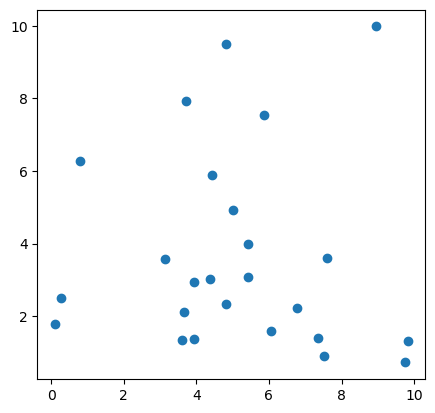

In [4]:
# Plot
point_gdf.plot();

### Lines
A line is really just a collection of points, so to create a line, the process is not that different than creating points. We just have to do it many times and connect them together. In this case, we are generating five different lines, each with a random number of points (vertices) betwen 2 and 10. Then, we simply use the uniform probability distribution to create X and Y values for each point.

In [5]:
# Define the bounding box (extent)
xmin, ymin, xmax, ymax = (0, 0, 10, 10)

# Generate random point coordinates
num_lines = 5

lines = []

for i in range(num_lines):
    # Calculate Number of Vertices in Line
    num_points_in_line = np.random.randint(2, 10)
    
    # Calculate Coordinates for each Vertex
    line_coords = [(np.random.uniform(xmin, xmax), np.random.uniform(ymin, ymax)) for _ in range(num_points_in_line)]
    
    # Append Vertices to List
    lines.append(LineString(line_coords))

In [6]:
# Create a GeoDataFrame from the random lines
line_gdf = gpd.GeoDataFrame(geometry=lines)

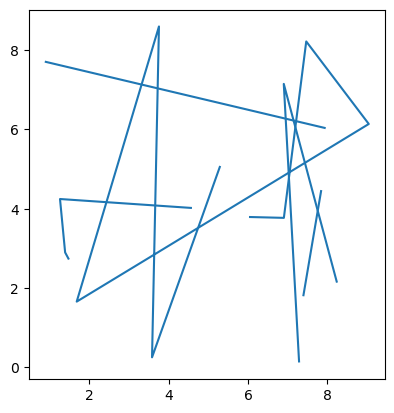

In [7]:
# Plot
line_gdf.plot();

### Polygons
There are many different ways to come up with polygons, but one easy way is to simply use the points we already generated and create a Voronoi diagram from them.

In [8]:
# Compute a Voronoi Diagram (Thiessen Polygons) using points from above
vor = Voronoi(np.array([[point.x, point.y] for point in point_geometry]))

# Extract the polygons
polygons = []

for region in vor.regions:
    if len(region) > 0 and -1 not in region:
        polygon_coords = [vor.vertices[i] for i in region]
        polygons.append(Polygon(polygon_coords))

In [9]:
# Create a GeoDataFrame from the polygons
poly_gdf = gpd.GeoDataFrame(geometry=polygons)

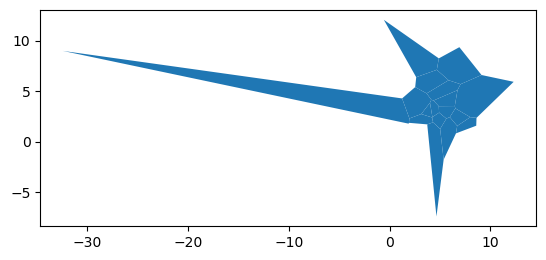

In [10]:
# Plot
poly_gdf.plot();

### Non-Random Polygons
We can also create regular polygons in a grid pattern quite easily. In this case, we can use a nested loop to come up with coordinates for the four corners of a grid cell.

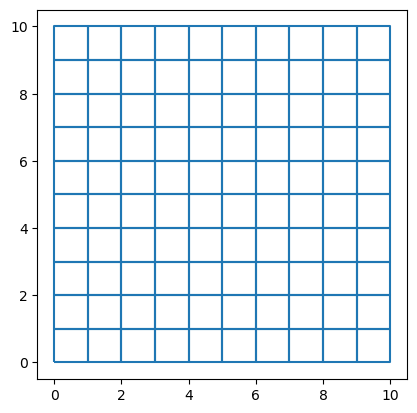

In [11]:
grid_cells = []

# Loop through X coordinates
for i in range(10):
    # Loop through Y coordinates
    for j in range(10):
        # Create grid cell
        cell = ((i, j), (i, j+1), (i+1, j+1), (i+1, j), (i, j))
        
        # Append cell to list
        grid_cells.append(Polygon(cell))

# Create a GeoDataFrame from the grid cells    
fishnet_gdf = gpd.GeoDataFrame(geometry=grid_cells)

# Plot
fishnet_gdf.boundary.plot();

### Lines from Polygons

With the Voronoi polygons created a couple cells up, we can also convert the boundaries of the polygons into lines. This provides us with yet another way to create lines. 

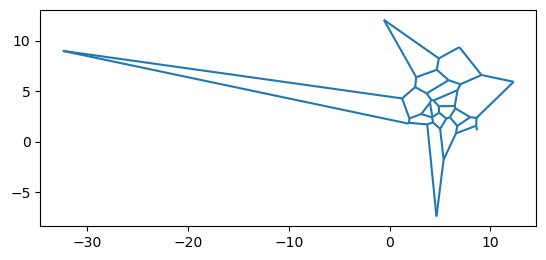

In [12]:
voronoi_lines = []

for edge in vor.ridge_vertices:
    if -1 not in edge:
        line_coords = [vor.vertices[i] for i in edge]
        voronoi_lines.append(LineString(line_coords))

# Create a GeoDataFrame from the Voronoi lines
line_gdf_from_poly = gpd.GeoDataFrame(geometry=voronoi_lines)

# Plot
line_gdf_from_poly.plot();

### Rasters

To create a random raster, we really just need to create a two-dimensional array, which could be a NumPy array, or a list of lists. If you chose to represent a raster as a list of lists, each sublist would represent a single row in the raster, therefore the number of sublists would indicated the number of rows and the number of values within a sublist would indicate the number of columns. We can then use a probability distribution to assign random values to each of the grid cells.

With a NumPy probability distribution, we can even specify how may values we want to randomly create by defining what the shape of the output array is (the number of rows and columns).

In [13]:
# Define array dimensions
rows, cols = 100, 100

# Generate random values between 0 and 100
raster_data = np.random.uniform(0, 100, (rows, cols))

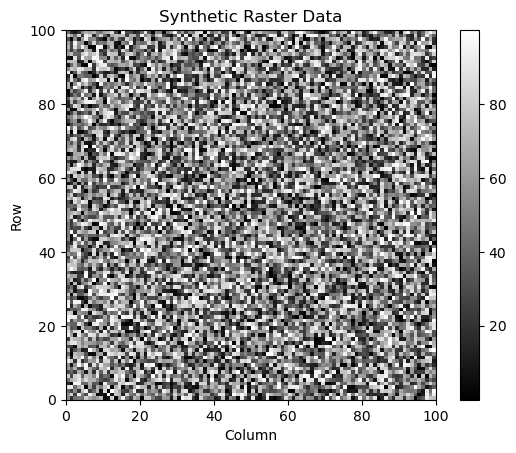

In [14]:
# Plot the data as a grayscale image
plt.imshow(raster_data, cmap='gray', extent=(0, cols, 0, rows), origin='lower')
plt.colorbar()
plt.title('Synthetic Raster Data')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

### Categorical Rasters

Using a probability distribution is good for continuous data, but what about categorical data, which is commonly found in raster data (land cover, for example)?

Luckily, we are able to randomly select a value from a predfined values using NumPy's choice functionality. We can then represent categories as integers and have each value in the raster fall into one of the predefined categories.

In [15]:
# Define the categories and their corresponding values
forest_value = 1
grassland_value = 2
urban_value = 3
water_value = 4

# Create a synthetic land cover array with random categories
categorical_raster_data = np.random.choice([forest_value, grassland_value, urban_value, water_value], (rows, cols))

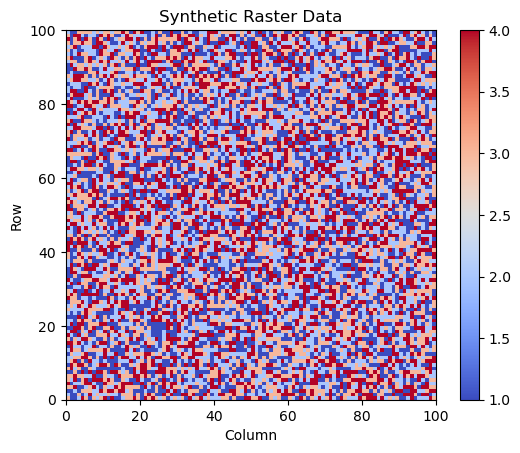

In [16]:
# Plot the data as a grayscale image
plt.imshow(categorical_raster_data, cmap='coolwarm', extent=(0, cols, 0, rows), origin='lower')
plt.colorbar()
plt.title('Synthetic Raster Data')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

### Points with Attributes

We have learned how to randomly generate points, but what about attributes?

Turns out, it's really easy! We can use the same tools we have been using and just create random values for each row in a DataFrame/GeoDataFrame. You could do this with any of the different probability distributions or even create categorical data.

In [17]:
# Using Previous Points GDF
mean = 1000
std_dev = 200
point_gdf['attribute_1'] = np.random.normal(mean, std_dev, num_points)

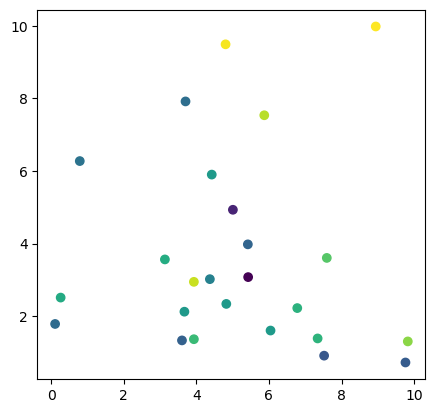

In [18]:
point_gdf.plot(column='attribute_1');